In [ ]:
# Add parent directory to Python path for module imports
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

# Depth from Defocus Tutorial

This notebook demonstrates the complete depth-from-defocus pipeline using alternating minimization.

## Overview
The pipeline consists of:
1. **Data Loading**: Load ground truth all-in-focus (AIF) image and depth map
2. **Forward Model**: Generate synthetic defocus stack from ground truth
3. **AIF Initialization**: Compute initial AIF using MRF optimization
4. **Alternating Minimization**: Jointly optimize depth and AIF
5. **Evaluation**: Compute accuracy metrics
6. **Post-processing (optional)**: Remove outliers

---

## Setup

First, import necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Custom modules for depth-from-defocus
import globals
import dataset_loader
import utils
import forward_model
import initialization
import coordinate_descent
import outlier_removal

/home/holly/Documents/depth-from-defocus/dfd/dfd-sparse/lib/python3.12/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


---

## Step 1: Load Example Data

Load a sample image from the NYUv2 dataset. This includes:
- **Ground truth AIF image**: The all-in-focus RGB image
- **Ground truth depth map**: Per-pixel depth values

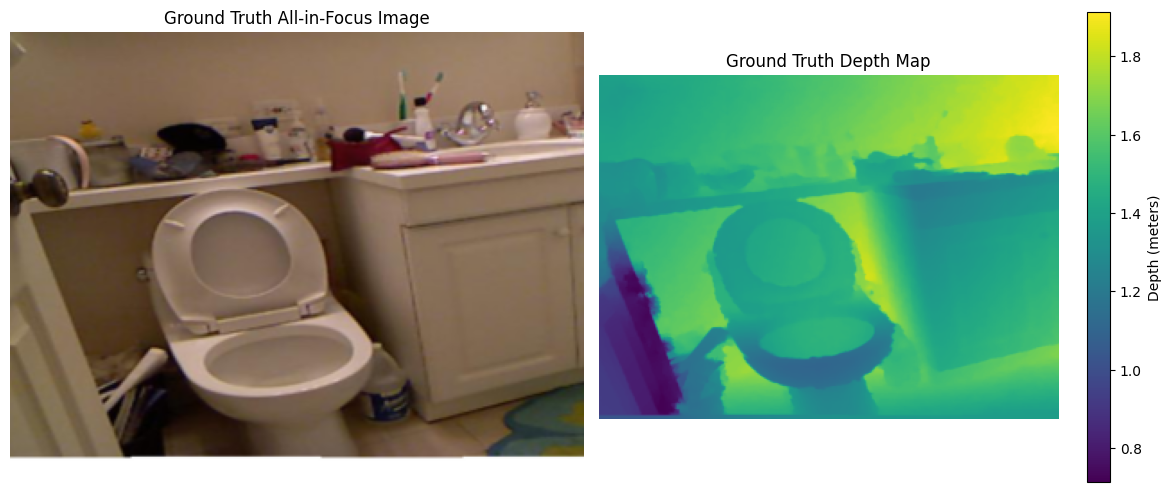

Image dimensions: 240 x 320
Adaptive kernel size set to: 11


In [2]:
# Initialize NYUv2 dataset configuration
globals.init_NYUv2()

# Load example image: ground truth AIF and depth map
gt_aif, gt_dpt, _ = dataset_loader.load_example_image(fs=5, res='half')

# Visualize ground truth AIF image
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(gt_aif / 255.)
plt.title('Ground Truth All-in-Focus Image')
plt.axis('off')

# Visualize ground truth depth map
plt.subplot(1, 2, 2)
plt.imshow(gt_dpt)
plt.title('Ground Truth Depth Map')
plt.colorbar(label='Depth (meters)')
plt.axis('off')
plt.tight_layout()
plt.show()

# Print image dimensions
width, height = gt_dpt.shape
print(f'Image dimensions: {width} x {height}')

# Set adaptive kernel size based on image dimensions
max_kernel_size = utils.kernel_size_heuristic(width, height)
print(f'Adaptive kernel size set to: {max_kernel_size}')
utils.update_max_kernel_size(max_kernel_size)

---

## Step 2: Generate Synthetic Defocus Stack

Use the forward model to generate a synthetic defocus stack from the ground truth depth and AIF image. This simulates capturing multiple images at different focus distances.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00733042..1.0363318].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009103269..1.0079689].


Defocus stack shape: (5, 240, 320, 3)
  - Number of focus levels: 5
  - Image dimensions: 240 x 320
  - Channels: 3


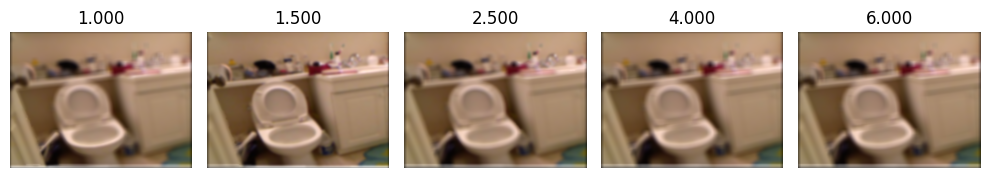

In [3]:
# Generate synthetically-blurred defocus stack
# This creates N images (N = fs = 5), each focused at a different depth
defocus_stack = forward_model.forward(gt_dpt, gt_aif)

print(f'Defocus stack shape: {defocus_stack.shape}')
print(f'  - Number of focus levels: {defocus_stack.shape[0]}')
print(f'  - Image dimensions: {defocus_stack.shape[1]} x {defocus_stack.shape[2]}')
print(f'  - Channels: {defocus_stack.shape[3]}')

# Visualize the defocus stack
# Each image is focused at a different depth from globals.Df
utils.plot_single_stack(defocus_stack / 255., globals.Df)

---

## Step 3: AIF Initialization

Compute an initial all-in-focus image using MRF optimization. This selects the sharpest pixel at each location while enforcing spatial smoothness using graph cuts (based on Suwajanakorn et al.).

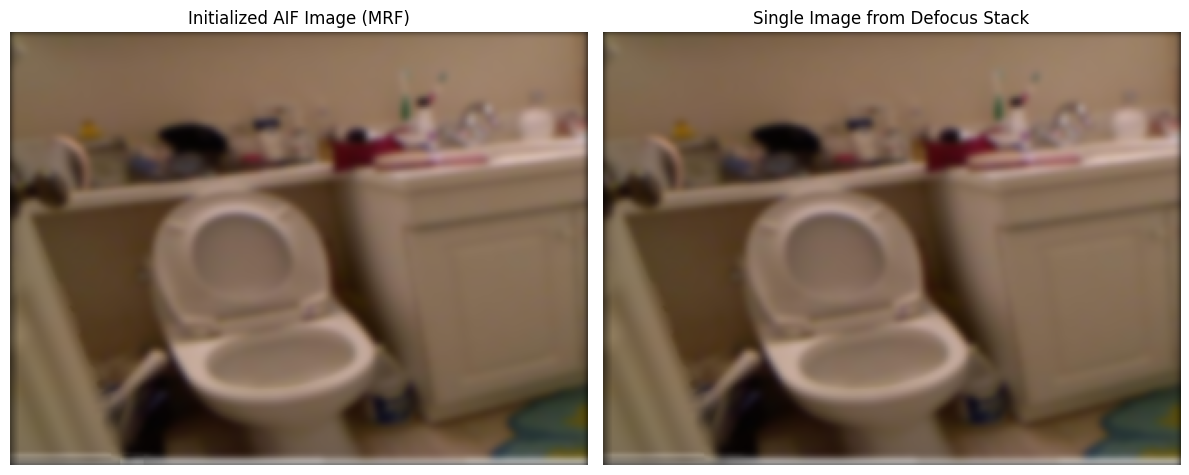

AIF initialization complete!


In [4]:
# Compute AIF initialization using MRF optimization
# - lmbda: controls tradeoff between two terms in optimization
# - sharpness_measure: method for computing sharpness ('sobel_grad', 'laplacian', 'log')
aif_init = initialization.compute_aif_initialization(
    defocus_stack, 
    lmbda=0.05, 
    sharpness_measure='sobel_grad'
)

# Visualize initialized AIF and compare to one image from the stack
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(aif_init / 255.)
plt.title('Initialized AIF Image (MRF)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(defocus_stack[1] / 255.)
plt.title('Single Image from Defocus Stack')
plt.axis('off')

plt.tight_layout()
plt.show()

print('AIF initialization complete!')

---

## Step 4: Coordinate Descent Optimization

Run the coordinate descent algorithm to jointly optimize the depth map and AIF image. The algorithm alternates between:
1. **Depth update**: Optimize depth given current AIF
2. **AIF update**: Optimize AIF given current depth

This example will take ~10 minutes to run.

### Parameters:
- `num_epochs`: Number of full alternating minimization iterations
- `num_Z`: Number of depth candidates to evaluate per pixel during grid search
- `T_0`: Initial number of bounded FISTA iterations
- `alpha`: Multiplier for FISTA iterations
- `nesterov_first`: Whether to first optimize for depth or AIF

Starting coordinate descent optimization...

Depth range: [ 0.1 - 10.0 ]
Created experiment folder: experiments/coord-descent_2026-02-13_04-05-02
Images in range [0-255]


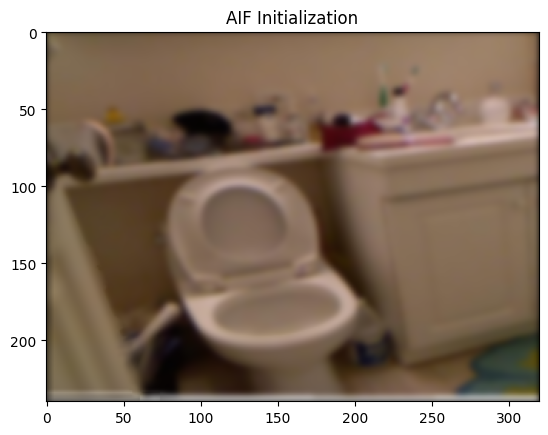

Iteration 0 



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.79it/s]


GRID SEARCH DURATION 20.955628871917725


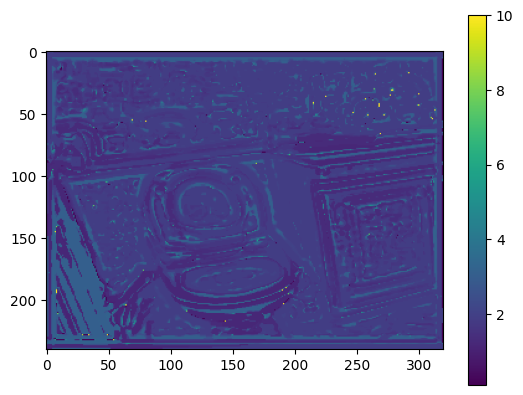


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 15.14068865776062


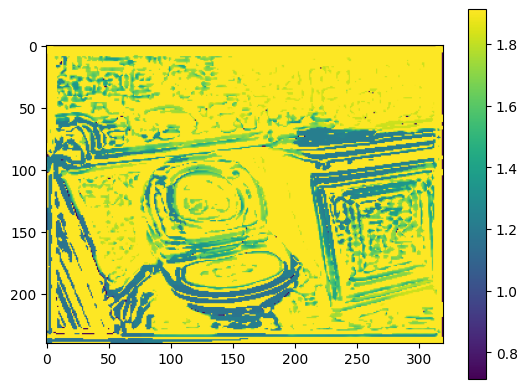

Loss: 22.301998 , TV: 32253.895

DPT result range: [ 0.104508504 , 9.995491 ]


Bounded FISTA...


Optimizing: 100%|██████████| 200/200 [01:12<00:00,  2.75it/s]


r1norm 2223.5537 norm(x) 51784.453
FISTA duration 77.23345279693604

AIF result range: [ 0.0 , 255.0 ]
Loss: 4.291883 , TV: 4915304.0


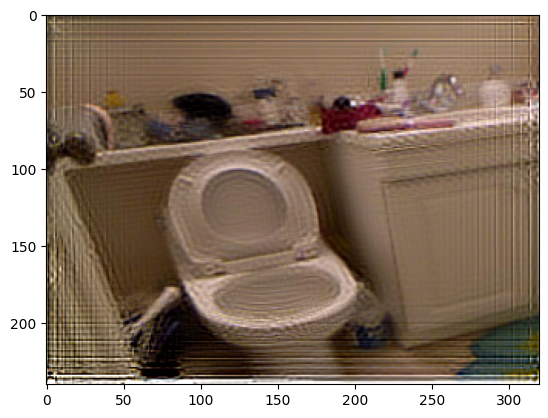

FULL ITER DURATION 115.98735618591309
T_i updated to 210


--------------------------

Iteration 1 



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.97it/s]


GRID SEARCH DURATION 20.24476194381714


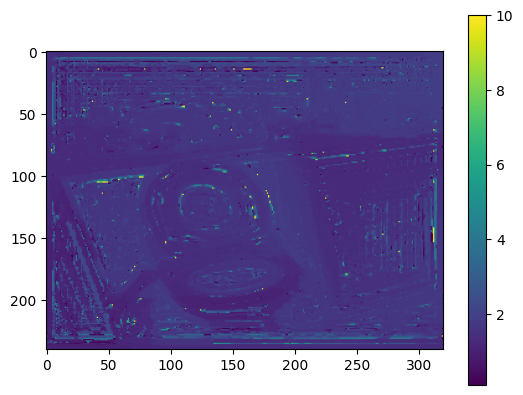


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 14.783509492874146


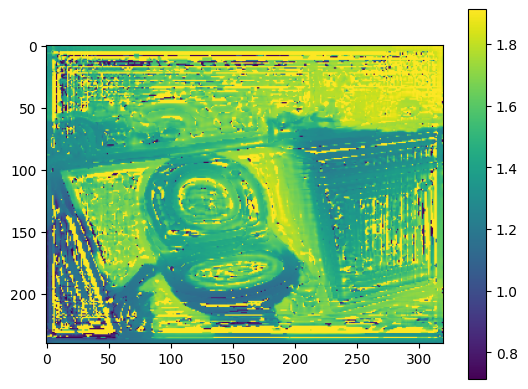

Loss: 1.5673965 , TV: 30899.777

DPT result range: [ 0.104508504 , 9.995491 ]


Bounded FISTA...


Optimizing: 100%|██████████| 210/210 [01:18<00:00,  2.68it/s]


r1norm 609.56433 norm(x) 51590.152
FISTA duration 80.9896023273468

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.32254556 , TV: 2710191.5


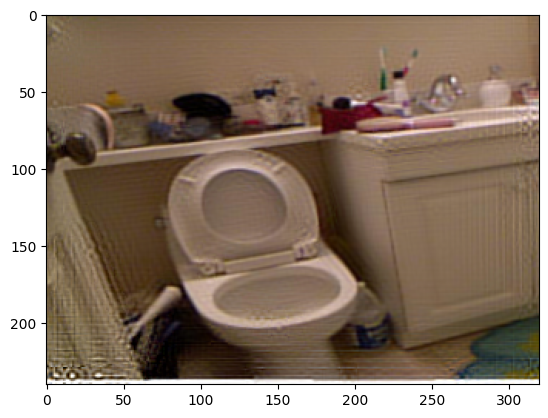

FULL ITER DURATION 118.20798873901367
T_i updated to 220


--------------------------

Iteration 2 



Grid search         : 100%|███████████████████| 100/100 [00:19<00:00,  5.16it/s]


GRID SEARCH DURATION 19.466066360473633


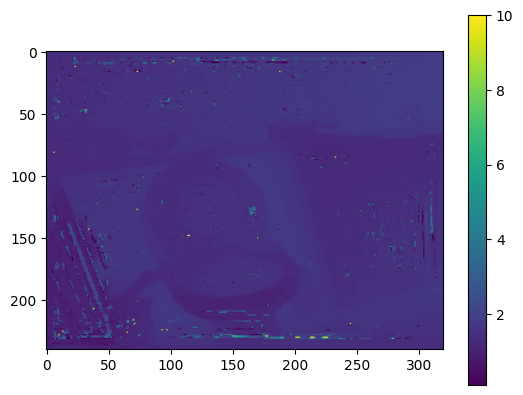


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 14.474601984024048


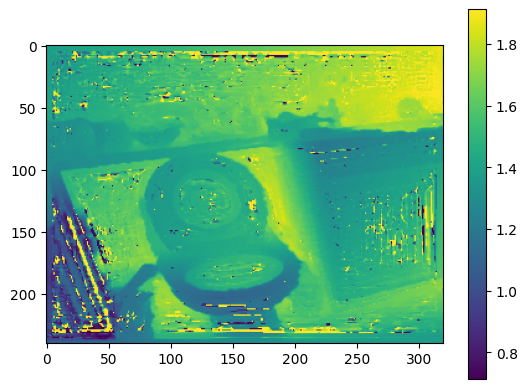

Loss: 0.10339128 , TV: 12321.639

DPT result range: [ 0.104508504 , 9.995491 ]


Bounded FISTA...


Optimizing: 100%|██████████| 220/220 [01:18<00:00,  2.82it/s]


r1norm 190.51648 norm(x) 51598.81
FISTA duration 80.87036156654358

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.031507224 , TV: 2220465.8


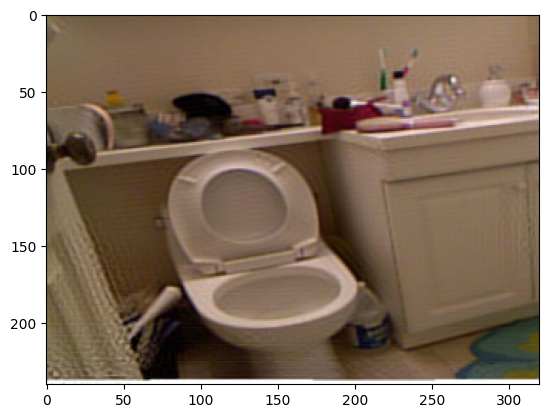

FULL ITER DURATION 116.91176056861877
T_i updated to 231


--------------------------

Iteration 3 



Grid search         : 100%|███████████████████| 100/100 [00:19<00:00,  5.23it/s]


GRID SEARCH DURATION 19.238377332687378


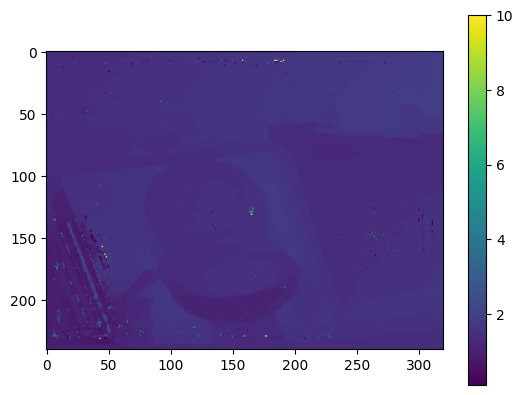


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 15.114990711212158


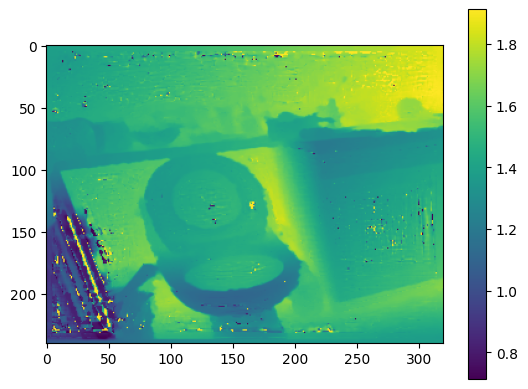

Loss: 0.015604141 , TV: 5070.291

DPT result range: [ 0.104508504 , 9.995491 ]


Bounded FISTA...


Optimizing: 100%|██████████| 231/231 [01:21<00:00,  2.83it/s]


r1norm 97.41574 norm(x) 51601.668
FISTA duration 84.61668348312378

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0082374 , TV: 2086677.6


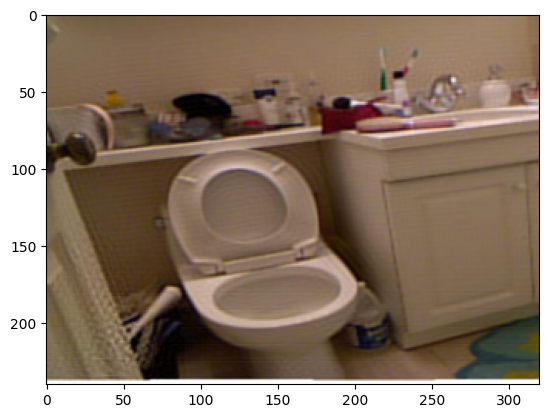

FULL ITER DURATION 121.25156927108765
T_i updated to 242


--------------------------

Iteration 4 



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.91it/s]


GRID SEARCH DURATION 20.488722324371338


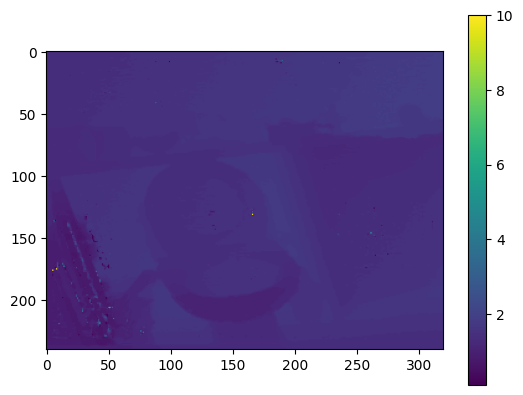


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 15.024471282958984


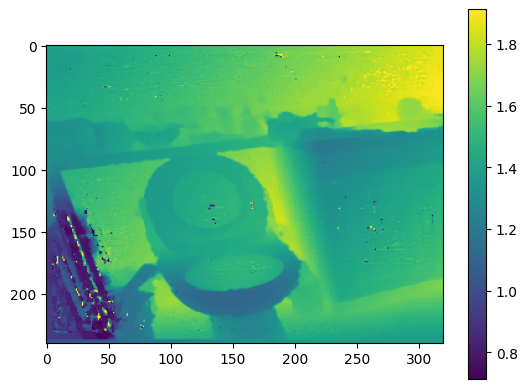

Loss: 0.0053603197 , TV: 2797.4446

DPT result range: [ 0.104508504 , 9.989918 ]


Bounded FISTA...


Optimizing: 100%|██████████| 242/242 [01:23<00:00,  2.89it/s]


r1norm 63.63013 norm(x) 51603.227
FISTA duration 86.56326866149902

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0035143232 , TV: 2044713.5


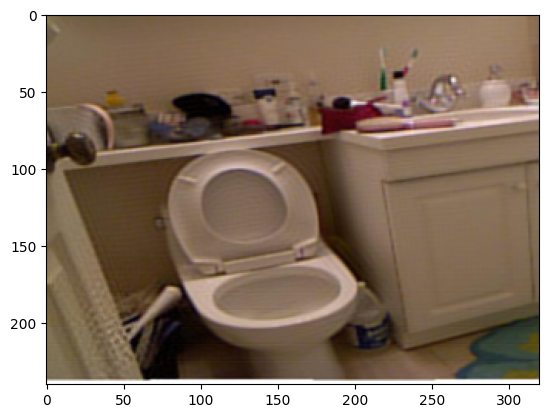

FULL ITER DURATION 124.26703214645386
T_i updated to 254


--------------------------


Optimization complete!


In [5]:
# Run coordinate descent optimization
print('Starting coordinate descent optimization...\n')

dpt, aif, _, _ = coordinate_descent.coordinate_descent(
    defocus_stack,
    # Optimization parameters
    num_epochs=5,           # Number of complete alternating minimization iters
    num_Z=100,              # Number of depth candidates to eval during grid search
    T_0=200,                # Initial FISTA iterations
    alpha=1.05,             # Multiplier for FISTA iterations
    nesterov_first=False,   # First solve for depth, then AIF
    # Initialization
    aif_init=aif_init,      # Use MRF-initialized AIF
    # Visualization
    show_plots=True,        # Display plots during optimization
    save_plots=False,       # Don't save plots to disk
    vmin=gt_dpt.min(),      # Min depth for visualization only
    vmax=gt_dpt.max(),      # Max depth for visualization only
    verbose=True            # Print progress
)

print('\nOptimization complete!')

---

## Step 5: Evaluate Results

Compute accuracy metrics to compare the estimated depth with ground truth:
- **RMS**: Root mean squared error
- **Rel**: Relative absolute error
- **δ_n**: Percentage of pixels where max(pred/gt, gt/pred) < 1.25^n

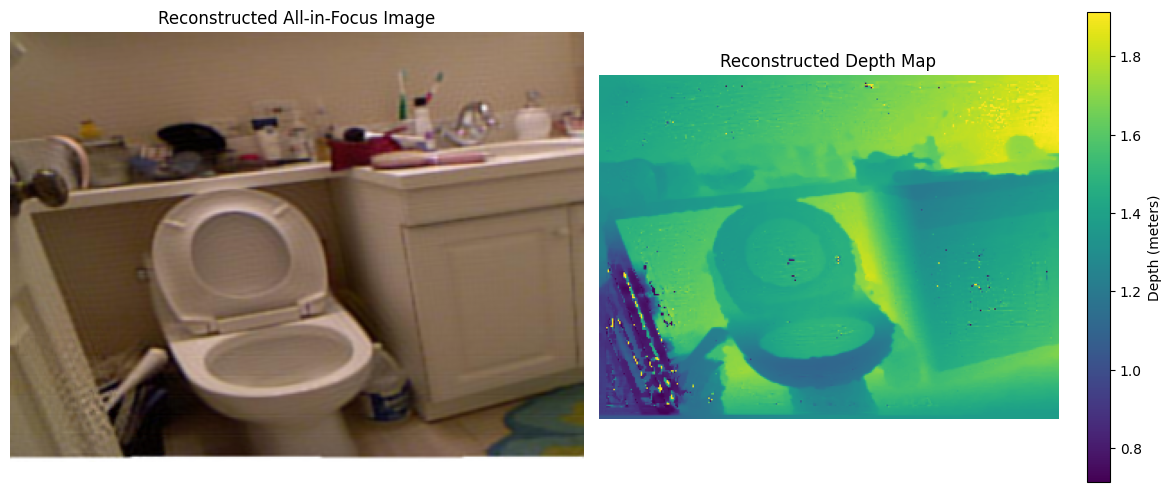

ACCURACY METRICS
RMS Error:           0.102075
Relative Error:      0.013135
δ < 1.25:            0.9885
δ < 1.25²:           0.9958
δ < 1.25³:           0.9975


In [10]:
# Visualize reconstructed AIF image
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(aif / 255.)
plt.title('Reconstructed All-in-Focus Image')
plt.axis('off')

# Visualize ground truth depth map
plt.subplot(1, 2, 2)
plt.imshow(dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.title('Reconstructed Depth Map')
plt.colorbar(label='Depth (meters)')
plt.axis('off')
plt.tight_layout()
plt.show()

# Compute accuracy metrics
rms = utils.compute_RMS(dpt, gt_dpt)
rel = utils.compute_AbsRel(dpt, gt_dpt)
accuracy_metrics = utils.compute_accuracy_metrics(dpt, gt_dpt)

# Display results
print('=' * 50)
print('ACCURACY METRICS')
print('=' * 50)
print(f'RMS Error:           {rms:.6f}')
print(f'Relative Error:      {rel:.6f}')
print(f'δ < 1.25:            {accuracy_metrics["delta1"]:.4f}')
print(f'δ < 1.25²:           {accuracy_metrics["delta2"]:.4f}')
print(f'δ < 1.25³:           {accuracy_metrics["delta3"]:.4f}')
print('=' * 50)

---

## Step 6: Outlier Removal (Optional)

Apply post-processing to remove outlier depth estimates. This identifies and removes unreliable depth estimates.

### Parameters:
- `tv_thresh`: TV threshold above which a pixel is flagged
- `patch_type`: Outlier detection strategy

Removing outliers...
found 3236 outliers


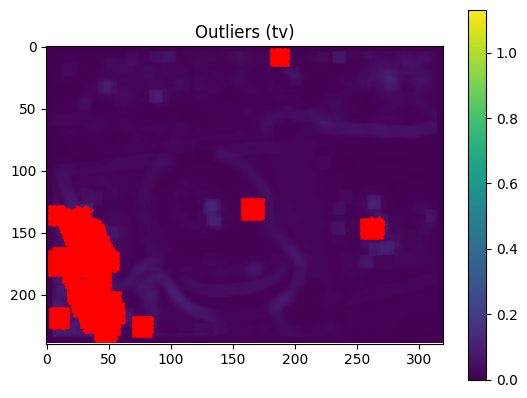

3236 / 3236 outliers removed
4.2135% of pixels flagged as outliers


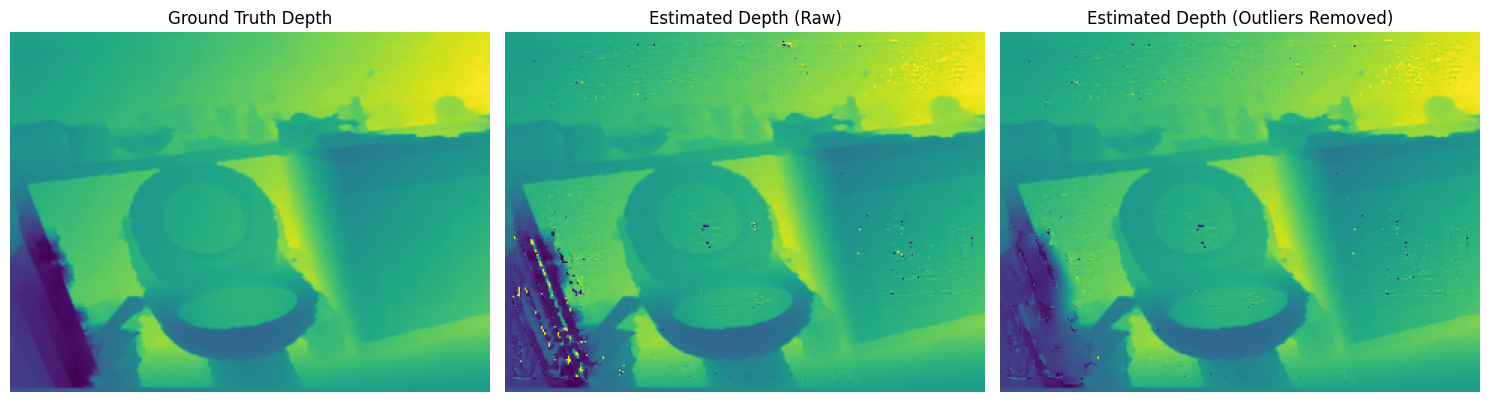

In [12]:
# Remove outlier depth estimates
depth_no_outliers, outlier_fraction = outlier_removal.remove_outliers(
    dpt, 
    aif,
    tv_thresh=0.15,     # TV threshold above which a pixel is flagged
    patch_type='tv'     # Use total variation strategy to detect outliers
)

print(f'{(outlier_fraction*100):.4f}% of pixels flagged as outliers')

# Visualize cleaned depth map
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.title('Ground Truth Depth')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.title('Estimated Depth (Raw)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(depth_no_outliers, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.title('Estimated Depth (Outliers Removed)')
plt.axis('off')

plt.tight_layout()
plt.show()